### Networks from other data sources

In [2]:
import pandas as pd
import networks.other_bio_networks as others
import datetime, pickle
from create_datasets import create_nx_datasets
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt


**1. Obtain other biological networks**

Obtain new biological networks for the AD gene set from different sources:
- 1. BioGRID: Protein-Protein Interactions (PPIs)
- 2. Human Reference Interactome (HuRI): PPIs
- 3. PPT-Ohmnet dataset from Stanford Network Analysis Project (SNAP): brain-specific PPIs
- 4. GIANT: functional network, brain-specific

In [ ]:
# BioGRID (PPI)
edgelist_biogrid = others.get_biogrid('data/AD_GDAs.txt')

# HuRI (PPI) - HuRI interactions were downloaded from HuRI webpage and then parsed to obtain the corresponding edgelist.
interactions_huri = pd.read_csv('data/other_networks/HuRI_download_interactions_dec_16_2021_11_54_03.csv', comment='#')
edgelist_huri = interactions_huri[['Interactor A Gene Name', 'Interactor B Gene Name']]
edgelist_huri = edgelist_huri[edgelist_huri['Interactor A Gene Name'] != edgelist_huri['Interactor B Gene Name']] # remove self loops
edgelist_huri.to_csv('data/other_networks/AD_HuRI_PPI.edgelist', sep='\t', index=None, header=False)

# PPT-Ohmnet (PPI, brain-specific)
network_snap = others.get_snap('data/AD_GDAs.txt')

# GIANT (functional network, brain-specific)
network_giant = others.get_giant('data/AD_GDAs.txt')

**2. Create graph datasets**

Create the correspoding graph-datasets for each newly obtained biological network.

In [ ]:
dataset = 'ADNI'
targets = ['PET', 'PETandDX']
networks = ['biogrid', 'huri', 'snap_brain', 'giant_brain', 'original']

for target in targets:
    for network in networks:

        outdir = f'data/graph_datasets/{target}'

        start_time = datetime.datetime.now()
        print()

        result_nodes = create_nx_datasets.main('data', dataset, target, 'AD', network, 'missense', None)
        print('Coding: number of missense variants per node')

        outfile = f'{outdir}/AD_PPI_{network}_missense.pkl'
        print('Resulting dataset saved at:', outfile)
        print()

        with open(outfile, 'wb') as f:
            pickle.dump(result_nodes, f)

        result_nodes_time = datetime.datetime.now()
        print('Processing time:', result_nodes_time - start_time)
        print('\n\n')

**3. Graph classification with GNNs**

We then evaluated and tested different GNNs in the framework called [GraphGym](https://github.com/snap-stanford/GraphGym) (You *et al.*, 2020).

Configuration and grid files employed are in the subdirectory [graphgym_files](graphgym_files).

Summarized results obtained by GraphGym and other models are in [results/GNNs_other_networks](results/GNNs_other_networks)

Next lines plot these results obtained using ADNI dataset (Figure 3 of the paper).

In [8]:
def barplot_comparision_others(target, bs, df, metric, title):
    
    colors = ["#E76BF3", "#9590ff", "#9590ff", "#9590ff", "#9590ff"]
    custom = sns.set_palette(sns.color_palette(colors))

    plt.figure(figsize=(6, 8))
    ax = sns.barplot(x = 'Dataset',
                     y = metric,
                     ci = 'sd',
                     data = df,
                     palette = custom)
    plt.axhline(y=bs, color='r', linestyle='dotted', label=f'Baseline model ({bs})')
    plt.legend(fontsize=14, loc='upper right')
    plt.ylim(0, 1.0)
    plt.xticks(fontsize=16, rotation=60)
    plt.yticks(fontsize=16)
    ax.xaxis.label.set_visible(False)
    plt.ylabel(f'{metric} obtained in test set', fontsize=16)
    plt.title(title, fontsize=16, fontweight='bold')
    plt.tight_layout(True)
    
    plt.savefig(f'figures/figure3{title}.pdf', dpi=500)
    plt.savefig(f'figures/figure3{title}.png', dpi=500)

/home/laura/anaconda3/envs/graphgym/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


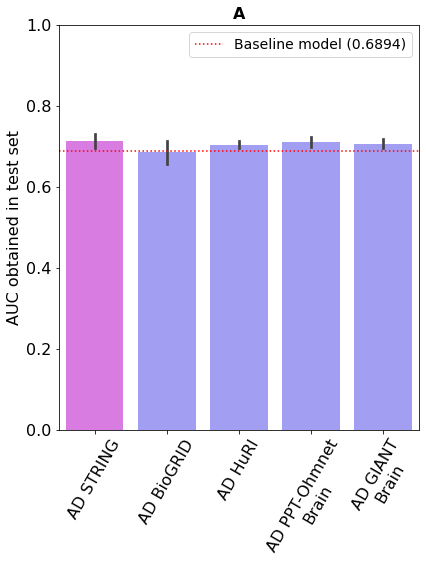

In [9]:
pet_results = pd.read_csv('results/GNNs_other_networks/2022_01_PET_others.csv')
barplot_comparision_others('PET', 0.6894, pet_results, 'AUC', 'A')

/home/laura/anaconda3/envs/graphgym/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


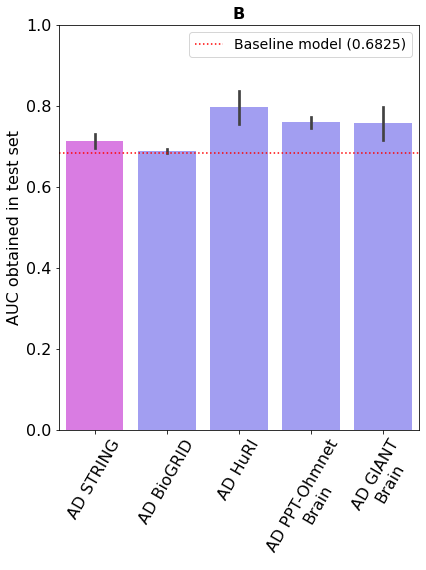

In [10]:
pet_results = pd.read_csv('results/GNNs_other_networks/2022_01_PETandDX_others.csv')
barplot_comparision_others('PETandDX', 0.6825, pet_results, 'AUC', 'B')